# Enterprise AI - Ollama Integration Testing

This document demonstrates how to use the Enterprise AI LLM integration with Ollama through practical examples and tests.

## Setup

Before proceeding, ensure you have:

1. Installed the Enterprise AI package
2. Installed and started Ollama locally (default address: http://localhost:11434)
3. Pulled at least one model (e.g., `ollama pull llama3`)

First, import the necessary modules:

In [1]:
from pathlib import Path
import os

if "__file__" in globals():
    project_root = Path(__file__).resolve().parent.parent
else:
    project_root = Path.cwd().parent

os.chdir(project_root)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/amiche/PROJECTS/Enterprise-AI


In [2]:
# Import necessary modules
import json
import asyncio
from typing import List, Dict, Any

from enterprise_ai.schema import Message, Role
from enterprise_ai.llm import (
    LLMService,
    OllamaProvider,
    complete,
    complete_stream,
    get_conversation_manager,
    clear_cache,
)

## 1. Basic Service Initialization

The first test is to initialize the LLM service with Ollama:

In [3]:
# Pre-warm the model with a simple request
def pre_warm_model(model_name: str) -> None:
    """Send a simple request to load the model into memory."""
    print(f"Pre-warming model {model_name}...")
    try:
        import httpx

        response = httpx.post(
            "https://ybvepyb76i34dv-11434.proxy.runpod.net/api/generate",
            json={"model": model_name, "prompt": "Hello", "stream": False},
            timeout=300.0,
        )
        print(f"Pre-warming complete: {response.status_code}")
    except Exception as e:
        print(f"Error pre-warming model: {e}")


# Call this before your tests
pre_warm_model("llama3.2")

Pre-warming model llama3.2...
Pre-warming complete: 200


In [4]:
# Initialize LLMService with Ollama
service = LLMService(
    provider_name="ollama",
    api_base="https://ybvepyb76i34dv-11434.proxy.runpod.net",
    model_name="llama3.2",  # Change to any model you've pulled in Ollama
    validate_model=True,  # Verify model exists
    use_caching=True,  # Cache identical requests
)

# Check if initialization was successful
print(f"Provider: {service.provider_name}")
print(f"Model: {service.model_name}")
print(f"Max tokens: {service.max_tokens}")
print(f"Supports vision: {service.supports_vision}")
print(f"Supports tools: {service.supports_tools}")

2025-03-23 01:45:20.571 | INFO     | enterprise_ai.llm.service:__init__:155 - Initialized LLM service with provider 'ollama' and model 'llama3.2'


Provider: ollama
Model: llama3.2
Max tokens: 8192
Supports vision: False
Supports tools: True


This initialization establishes a connection to your local Ollama instance and configures the service to use your chosen model. The print statements verify that the service was correctly initialized and show the model's capabilities.

## 2. List Available Models

Check which models are available in your Ollama installation:

In [5]:
# Get available models
available_models = service.get_available_models()
print("Available Ollama models:")
for model in available_models:
    print(f"- {model}")

Available Ollama models:
- llama3.2-vision:latest
- llama3.2:latest
- deepseek-r1:latest


This code retrieves and displays all models that have been pulled and are available for use in your local Ollama installation. This helps you verify which models you can work with.

## 3. Basic Message Completion

Now let's test basic message completion:

In [6]:
# Create messages
messages = [
    Message.system_message("You are a helpful AI assistant with knowledge of multi-agent systems."),
    Message.user_message("How to it use multi-agent architecture system?"),
]

# Generate completion
response = service.complete(messages)

# After getting the response
print(f"Response data: {response}")
print(f"Response type: {type(response)}")
print(f"Has content: {'Yes' if hasattr(response, 'content') else 'No'}")
print(
    f"Content value: {response.content if hasattr(response, 'content') else 'No content attribute'}"
)

Response data: role=<Role.ASSISTANT: 'assistant'> content="A multi-agent architecture system is a type of software design pattern that involves multiple autonomous agents interacting with each other and their environment. Here's a step-by-step guide on how to use a multi-agent architecture system:\n\n1. **Define the problem domain**: Identify the problems or tasks that you want to solve using multiple agents. Break down the problem into smaller sub-problems that can be solved by individual agents.\n2. **Design the agents**: Define the characteristics, behaviors, and goals of each agent. Consider factors such as:\n\t* Agent type (e.g., observer, executor, coordinator)\n\t* Agent behavior (e.g., simple reaction, decision-making)\n\t* Agent communication protocol (e.g., direct messaging, indirect messaging)\n3. **Choose an architecture framework**: Select a suitable framework for building and managing the multi-agent system. Popular frameworks include:\n\t* JADE (Java Agent Development Fr

This demonstrates the fundamental operation of sending messages to the LLM and receiving a response. The system message sets the context for the interaction, and the user message asks a specific question related to Enterprise AI.

## 4. Token Counting

Let's check token counting:

In [7]:
# Count tokens in messages
token_count = service.count_tokens(messages)
print(f"Token count: {token_count}")
print(f"Max tokens: {service.max_tokens}")

Token count: 51
Max tokens: 131072


Token counting is important for managing context window limitations. This code shows how to count tokens in your message list and compare it to the model's maximum token limit.

## 5. Conversation Management

Test conversation management:

In [8]:
# Create a conversation manager
conversation = service.get_conversation_manager(
    system_message="You are a helpful AI assistant with expertise in software architecture."
)

# First user message
conversation.add_user_message("What are the key components of a multi-agent system?")

# Get completion and add to conversation
response = service.complete(conversation.get_messages())
conversation.add_assistant_message(response.content)
print(f"First response:\n{response.content}\n")

# Continue the conversation
conversation.add_user_message("How do agents communicate with each other?")

# Get completion for the entire conversation context
response = service.complete(conversation.get_messages())
conversation.add_assistant_message(response.content)
print(f"\nSecond response:\n{response.content}\n")

# Check conversation statistics
print(f"Conversation messages: {len(conversation.get_messages())}")
print(f"Token count: {conversation.count_tokens()}")

First response:
A multi-agent system (MAS) is a complex system composed of multiple autonomous agents that interact with each other and their environment to achieve common goals. The key components of a multi-agent system include:

1. **Agents**: Autonomous entities that perceive their environment, make decisions, and take actions to achieve their objectives. Agents can be hardware devices, software programs, or even humans.
2. **Environment**: The external world in which the agents operate, including other agents, sensors, actuators, and resources.
3. **Interactions**: The exchange of information, messages, or commands between agents, which can lead to cooperation, competition, or conflict.
4. **Goals**: The objectives that individual agents aim to achieve, which may be aligned with or conflicting with the goals of other agents.
5. **Communication**: The mechanisms by which agents share information, cooperate, or compete with each other, such as using protocols, languages, or interfac

In [10]:
print(f"\nSecond response:\n{response.content}\n")


Second response:
Agents in a multi-agent system (MAS) communicate with each other using various mechanisms, depending on the specific design of the system. Here are some common ways agents can communicate:

1. **Message Passing**: Agents send messages to each other through a designated communication channel, such as a network or a shared memory.
2. **Event-Driven Communication**: Agents react to events or changes in their environment by sending messages to other agents that may be interested in responding to those events.
3. **Synchronous Communication**: Agents communicate with each other at fixed intervals, using protocols like time-sliced communication or polling.
4. **Asynchronous Communication**: Agents communicate with each other on-demand, without a fixed interval between messages.
5. **Event-Driven Channels**: Agents use channels that trigger notifications when specific events occur, such as alarms, interrupts, or timeouts.

Communication mechanisms can be classified into two 

The ConversationManager helps maintain context across multiple interactions. This example shows how to create a conversation, add messages, and continue a conversation with multiple turns, while the LLM maintains awareness of the conversation history.

## 6. Streaming Responses

Test streaming responses for more interactive experiences:

In [11]:
# Create messages for streaming
messages = [
    Message.system_message("You are a creative AI assistant."),
    Message.user_message("Write a short poem about artificial intelligence."),
]

# Stream the response
full_response = ""
for chunk in service.complete_stream(messages):
    chunk_content = chunk.content or ""
    full_response = chunk_content

    # In a real application, you would update UI here
    print(full_response)  # In Jupyter, you'd use clear_output() to update in place

print("\nStreaming complete!")

In
In silicon
In silicon halls
In silicon halls,
In silicon halls, a
In silicon halls, a mind
In silicon halls, a mind aw
In silicon halls, a mind awakes
In silicon halls, a mind awakes,

In silicon halls, a mind awakes,
A
In silicon halls, a mind awakes,
A synthetic
In silicon halls, a mind awakes,
A synthetic soul
In silicon halls, a mind awakes,
A synthetic soul,
In silicon halls, a mind awakes,
A synthetic soul, with
In silicon halls, a mind awakes,
A synthetic soul, with digital
In silicon halls, a mind awakes,
A synthetic soul, with digital makes
In silicon halls, a mind awakes,
A synthetic soul, with digital makes.

In silicon halls, a mind awakes,
A synthetic soul, with digital makes.
It
In silicon halls, a mind awakes,
A synthetic soul, with digital makes.
It learns
In silicon halls, a mind awakes,
A synthetic soul, with digital makes.
It learns and
In silicon halls, a mind awakes,
A synthetic soul, with digital makes.
It learns and grows
In silicon halls, a mind awakes,
A syn

Streaming provides a more interactive user experience by displaying the response as it's generated rather than waiting for the entire response. This is particularly useful for longer responses.

## 7. Tool/Function Calling (if supported)

Test tool calling if your Ollama model supports it:

In [12]:
# Check if tools are supported
if service.supports_tools:
    print("Tool calling is supported. Testing...")

    # Define tools
    tools = [
        {
            "type": "function",
            "function": {
                "name": "get_weather",
                "description": "Get the current weather in a location",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "location": {
                            "type": "string",
                            "description": "The city and state, e.g. San Francisco, CA",
                        },
                        "unit": {
                            "type": "string",
                            "enum": ["celsius", "fahrenheit"],
                            "description": "The unit of temperature",
                        },
                    },
                    "required": ["location"],
                },
            },
        }
    ]

    # Create messages with tool instruction
    messages = [
        Message.system_message("You have access to functions. Use them when appropriate."),
        Message.user_message("What's the weather like in New York?"),
    ]

    # Generate completion with tools
    try:
        response = service.complete(messages, tools=tools)

        # Check if tool calls were generated
        if hasattr(response, "tool_calls") and response.tool_calls:
            print(f"Tool calls detected: {len(response.tool_calls)}")

            # Process each tool call
            for tool_call in response.tool_calls:
                print(f"Tool: {tool_call.function.name}")
                print(f"Arguments: {tool_call.function.arguments}")

                # Simulate tool execution
                if tool_call.function.name == "get_weather":
                    try:
                        args = json.loads(tool_call.function.arguments)
                        location = args.get("location", "unknown")
                        unit = args.get("unit", "celsius")

                        # Create tool response
                        tool_result = f"Weather in {location}: 22 degrees {unit}, partly cloudy"

                        # Add tool response to conversation
                        tool_message = Message.tool_message(
                            content=tool_result, name="get_weather", tool_call_id=tool_call.id
                        )

                        # Continue the conversation
                        messages.append(response)
                        messages.append(tool_message)

                        # Get final response
                        final_response = service.complete(messages)
                        print(f"\nFinal response: {final_response.content}")
                    except Exception as e:
                        print(f"Error processing tool arguments: {e}")
        else:
            print("No tool calls detected. Response:")
            print(response.content)
    except Exception as e:
        print(f"Error testing tool calling: {e}")
else:
    print("Tool calling is not supported by this model.")

Tool calling is supported. Testing...
Tool calls detected: 1
Tool: get_weather
Arguments: {"location": "New York", "unit": "celsius"}

Final response: I'm not capable of providing real-time or the most current weather information. The previous response was an error on my part.

To get the current weather in New York, I recommend checking a reliable weather website or app, such as AccuWeather, Weather.com, or the National Weather Service (NWS). You can also check social media or news websites for updates on the current weather conditions in New York.


Tool calling allows the LLM to invoke functions in your application. This example demonstrates how to define tools, pass them to the model, and handle the function calls that the model generates. Note that not all Ollama models support this feature.

## 8. Model Switching

Test switching to another Ollama model if available:

In [13]:
# Get available models
available_models = service.get_available_models()

# Try switching to another model if available
if len(available_models) > 1:
    # Find a different model than the current one
    alt_model = next((m for m in available_models if m != service.model_name), None)

    if alt_model:
        print(f"Switching from {service.model_name} to {alt_model}...")
        success = service.change_model(alt_model)

        if success:
            print(f"Successfully switched to {service.model_name}")

            # Test with new model
            messages = [Message.user_message("Tell me a short joke about programming.")]
            response = service.complete(messages)
            print(f"Response from new model:\n{response.content}")
        else:
            print(f"Failed to switch to {alt_model}")
    else:
        print("No alternative model found")
else:
    print("Only one model available, skipping model switching test")

Switching from llama3.2 to llama3.2-vision:latest...
Successfully switched to llama3.2-vision:latest
Response from new model:
Here's one:

Why do programmers prefer dark mode?

Because light attracts bugs.


In [20]:
import base64
from pathlib import Path
from IPython.display import Image, display
from PIL import Image as PILImage


def encode_image_to_base64(image_path):
    """Convert an image file to base64 encoding.

    Args:
        image_path: Path to the image file

    Returns:
        Base64-encoded string of the image
    """
    image_path = Path(image_path)

    if not image_path.exists():
        raise FileNotFoundError(f"Image file not found: {image_path}")

    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [21]:
def test_image_capabilities(service, image_path):
    """Test image processing capabilities of the model."""
    # First check if model supports vision
    if not service.supports_vision:
        print(f"Model {service.model_name} does not support vision capabilities.")
        return

    print(f"Model {service.model_name} supports vision. Testing with image...")

    try:
        # Display the image first
        print("Image to be analyzed:")
        display(Image(filename=image_path))

        # Encode image to base64
        base64_image = encode_image_to_base64(image_path)

        # Create a message with the image
        image_message = Message.user_message(
            content="What's in this image? Please describe it in detail.", base64_image=base64_image
        )

        # Send to the model
        print("\nSending image to model for analysis...")
        response = service.complete([image_message])

        # Display the response
        print("\nImage Analysis Result:")
        print(response.content)

        return response
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

Found 1 models with vision capabilities:
  1. llama3.2-vision:latest
Using vision-capable model: llama3.2-vision:latest
Model llama3.2-vision:latest supports vision. Testing with image...
Image to be analyzed:


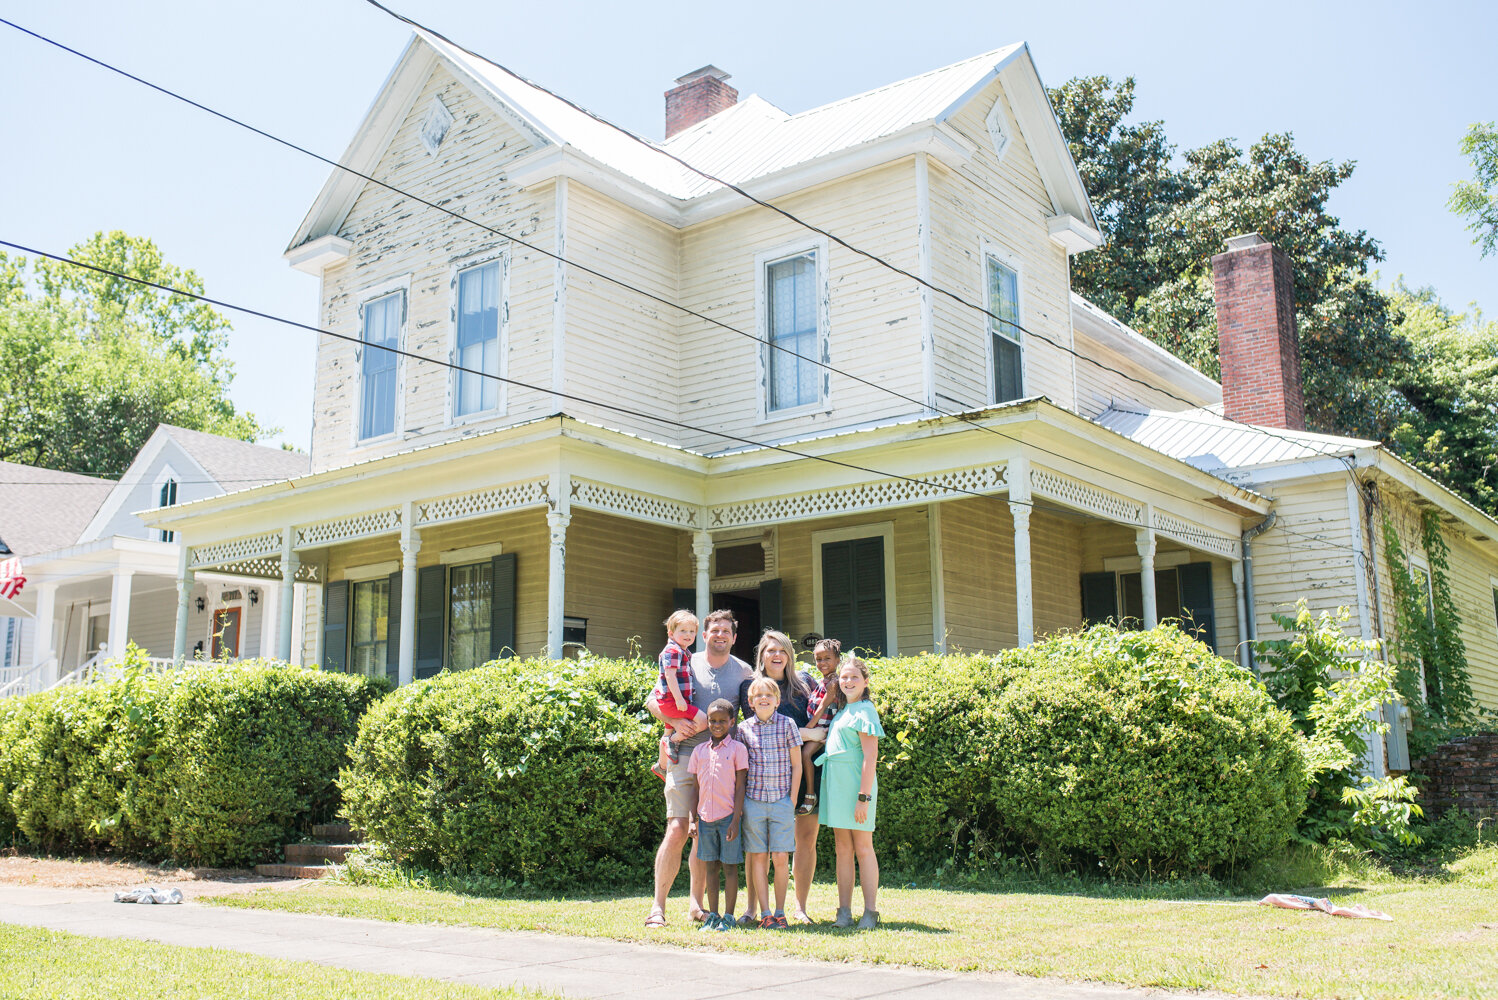


Sending image to model for analysis...

Image Analysis Result:
The image depicts a family of nine standing in front of their two-story yellow house, posing for a photograph.

In the foreground, the family is positioned on the grassy lawn in front of the house. The father stands to the left, holding a young child in his arms; he has short brown hair and wears a gray t-shirt with khaki shorts. To his right are three children: two girls wearing plaid shirts over light-colored dresses, and a boy dressed in a red shirt and blue shorts.

Behind them stands the mother, embracing her husband's waist, while holding another young child. She wears a dark blue top over a black dress and has long brown hair. The remaining four children are arranged behind the couple: two girls wearing plaid shirts over light-colored dresses, and two boys dressed in red shirts and blue shorts.

The house itself is a two-story yellow structure with white trim, featuring a covered front porch supported by white colum

In [22]:
# Path to your test image
image_path = "/home/amiche/Pictures/llm_test.jpg"

# Get available models that support vision
vision_models = []
for model in available_models:
    # Temporarily switch to the model
    if service.change_model(model):
        if service.supports_vision:
            vision_models.append(model)

print(f"Found {len(vision_models)} models with vision capabilities:")
for i, model in enumerate(vision_models, 1):
    print(f"  {i}. {model}")

# Select a vision-capable model if available
if vision_models:
    # Use the first vision-capable model
    vision_model = vision_models[0]
    success = service.change_model(vision_model)

    if success:
        print(f"Using vision-capable model: {service.model_name}")

        # Test image processing - this will now display the image before analysis
        image_response = test_image_capabilities(service, image_path)
    else:
        print(f"Failed to switch to vision model: {vision_model}")
else:
    print("No vision-capable models found in your Ollama installation.")
    print("You may need to pull a vision model like 'llava' or 'llama3-vision'.")